In [254]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
%matplotlib inline



import numpy as np
import autoreject
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import mne
import os
import sys
from atpbar import atpbar
import glob
from mne.stats import permutation_cluster_test
from scipy.stats import ttest_rel
from mne.channels import make_standard_montage
from mne.viz import plot_topomap
from mne.stats import permutation_cluster_1samp_test



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Suppress MNE output
#mne.set_log_level('WARNING')
mne.set_log_level('ERROR')
#mne.set_log_level('CRITICAL')
#mne.set_log_level('INFO')



## Import evoked responses into big dictionary

In [9]:
# Importing the data
evokeds = {}
for meditation in ['jhana', 'mindfulness']:
    evokeds[meditation] = {}
    evokeds[meditation]['all'] = []
    evokeds[meditation]['std'] = []
    evokeds[meditation]['dev'] = []
    evokeds[meditation]['mmn'] = []


#for sub in [0,1,2,4,7,8,9]:
for sub in range(10):
    for meditation in ['jhana', 'mindfulness']:
        paths = glob.glob(f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_first_tone/sub{sub}-day*-{meditation}_epo.fif')
        epochs_list = [mne.read_epochs(path) for path in paths]
        epochs_list_picks = []

        
        
        for i in range(len(epochs_list)):
            epochs_list[i] = epochs_list[i].interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
                
        concatenated_epochs = mne.concatenate_epochs(epochs_list)
        evokeds[meditation]['std'].append(concatenated_epochs['1'].average())
        evokeds[meditation]['dev'].append(concatenated_epochs['-1'].average())
        evokeds[meditation]['mmn'].append(mne.combine_evoked([evokeds[meditation]['dev'][-1], evokeds[meditation]['std'][-1]], weights=[1, -1]))
        evokeds[meditation]['all'].append(concatenated_epochs.average())


## Cluster based permutation test

In [128]:
# function to cut the evokeds array

def cut_array(evokeds_array, start,end, channel_selection=None, channel_names=None):
    start_samp = int(np.round((start+0.1)*256))
    end_samp = int(np.round((end+0.1)*256))
    
    if channel_selection == None: 
        evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp, :]   
    else:
        channel_indices = [channel_names.index(ch) for ch in channel_selection if ch in channel_names]
        evokeds_array_t = evokeds_array[:,:,:,start_samp:end_samp, channel_indices]   
    return (evokeds_array_t)


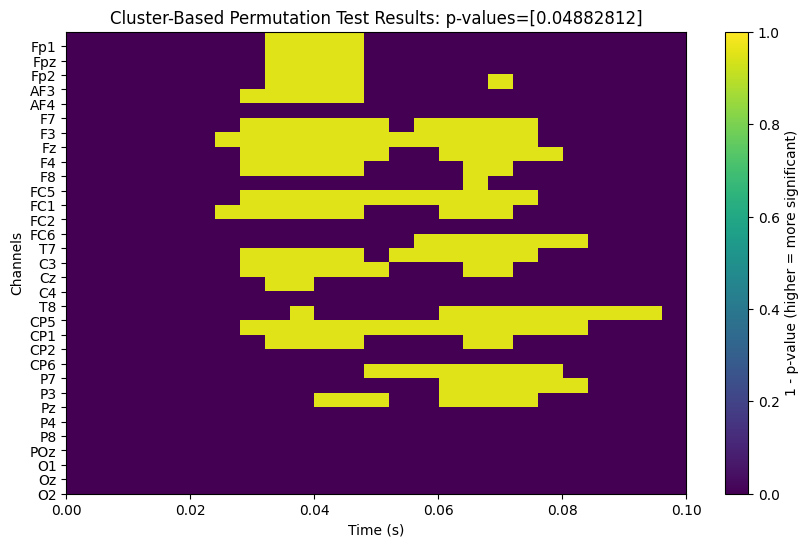

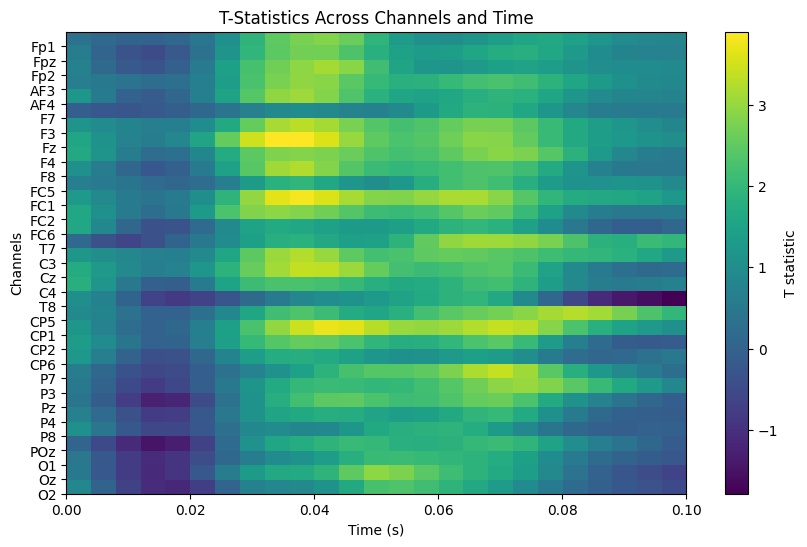

significant_indices:
[ 0  1  2  3  4  6  7  8  9 10 11 12 14 15 16 17 19 20 21 23 24 25]


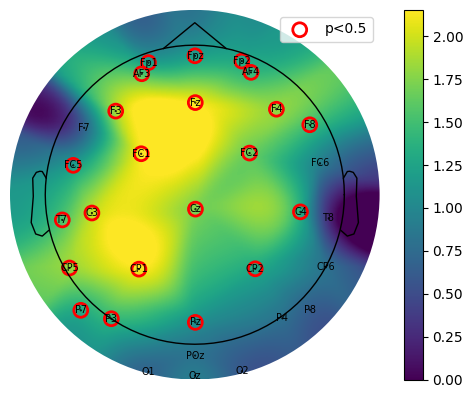

In [271]:
start = 0
end = 0.1
p_threshold = 0.5

sample_n = len(evokeds['jhana']['std'][0].get_data().T)
ch_adjacency, channel_selection = mne.channels.find_ch_adjacency(evokeds['jhana']['std'][0].info, 'eeg')

evokeds_array = np.zeros([10,2,4,sample_n,len(channel_selection)])
for sub in range(10):
    for meditation_n, meditation in enumerate(['jhana', 'mindfulness']):
        for condition_n, condition in enumerate(['std','dev','mmn', 'all']):
            evokeds_array[sub,meditation_n,condition_n,:,:] = evokeds[meditation][condition][sub].copy().pick_channels(channel_selection).get_data().T

evokeds_array_t = cut_array(evokeds_array, start, end)

#X =[evokeds_array_t[:,0,3,:,:], evokeds_array_t[:,1,3,:,:]]
#threshold_tfce = dict(start=0.2, step=0.1)
#T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=None, n_permutations=8192)


X_diff = evokeds_array_t[:, 0, 3, :, :] - evokeds_array_t[:, 1, 3, :, :]  # Shape: (10, n_channels, n_timepoints)

T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    X_diff, threshold=None, n_permutations=8192, tail=0, adjacency=ch_adjacency
)


time_series = [
    [evokeds_array[:,0,3,:].mean(axis=(0,2)), 'jhana', 'dashdot'],
    [evokeds_array[:,1,3,:].mean(axis=(0,2)), 'mindfulness', 'dashdot'],
]


###########################
### 2D Plot of clusters ###
###########################


# Input variables: T_obs, clusters, cluster_p_values
n_channels, n_times = T_obs.T.shape

# Define the sampling rate and time window
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)

# Initialize a 2D matrix for visualization
cluster_matrix = np.zeros((n_channels, n_times))

# Populate the matrix with cluster p-values
for i, cluster in enumerate(clusters):
    p_val = cluster_p_values[i]
    if p_val < p_threshold:  # Only include significant clusters
        for t, ch in zip(cluster[0], cluster[1]):
            cluster_matrix[ch, t] = 1 - p_val  # Higher intensity for smaller p-values

# Create the plot
plt.figure(figsize=(10, 6))
norm = Normalize(vmin=0, vmax=1)  # Normalize values between 0 and 1
plt.imshow(cluster_matrix, 
           aspect='auto', 
           cmap='viridis', 
           norm=norm,
           origin='upper', 
           extent=[times[0], times[-1], 0, n_channels])

# Add channel labels
plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

# Add colorbar for p-value gradient
cbar = plt.colorbar()
cbar.set_label("1 - p-value (higher = more significant)")

# Label axes
selected_cluster_p = cluster_p_values[cluster_p_values<p_threshold]
plt.title(f"Cluster-Based Permutation Test Results: p-values={selected_cluster_p}")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()



##########################
### 2D Plot of T-Stats ###
##########################


# Input variables: T_obs
n_channels, n_times = T_obs.T.shape
sampling_rate = 256  # Hz

# Calculate time points in seconds
times = np.linspace(start, end, n_times)


# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(T_obs.T, aspect='auto', 
           #cmap='coolwarm', 
           origin='upper',
           extent=[times[0], times[-1], 0, n_channels])

plt.yticks(ticks=np.arange(n_channels), labels=channel_selection[::-1])

cbar = plt.colorbar()
cbar.set_label("T statistic")

# Label axes
plt.title("T-Statistics Across Channels and Time")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.show()






################################
### Find significant indices ###
################################

channel_selection = evokeds['jhana']['std'][0].ch_names

# Find significant clusters
significant_clusters = np.where(cluster_p_values < p_threshold)[0]

# Extract significant channel indices
significant_channels = []  # Use a set to avoid duplicates
for cluster_idx in significant_clusters:
    cluster = clusters[cluster_idx]    
    significant_channels.append(cluster[1])

significant_indices = np.unique(np.concatenate(significant_channels))
print ('significant_indices:')
print(significant_indices)

######################
### Plot topo maps ###
######################

# get positions for topo maps:
montage = mne.channels.make_standard_montage('standard_1020')
selected_channels = [ch for ch in montage.ch_names if ch in channel_selection]
selected_positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in selected_channels])



fig, ax = plt.subplots()
im, _ = plot_topomap(
    T_obs.mean(axis=0), 
    pos=selected_positions, 
    names=channel_selection,
    axes=ax,
    cmap='viridis', 
    contours=0,
    show=False  # Prevent automatic display
)

# Overlay significant channels with bold markers
for idx in significant_indices:
    ax.scatter(
        selected_positions[idx, 0], 
        selected_positions[idx, 1], 
        s=100,  # Marker size
        edgecolor='red',  # Outline color
        facecolor='none',  # Hollow circle
        linewidth=2,  # Line thickness for boldness
        label=f'p<{p_threshold}' if idx == significant_indices[0] else None  # Add label only once
    )

# Add legend for significant channels
ax.legend(loc='upper right')

# Display the plot
plt.colorbar(im, ax=ax)
plt.show()


## Compare evokeds

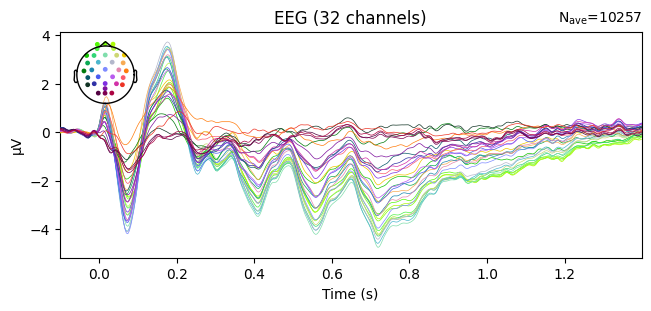

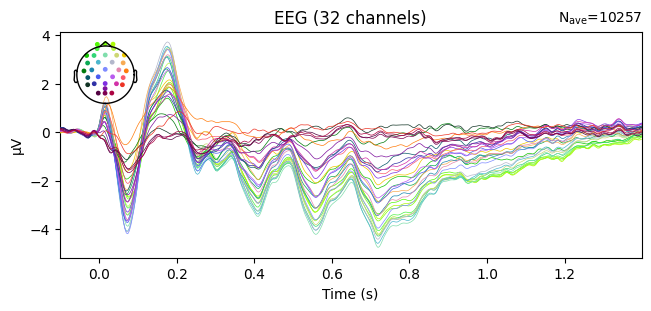

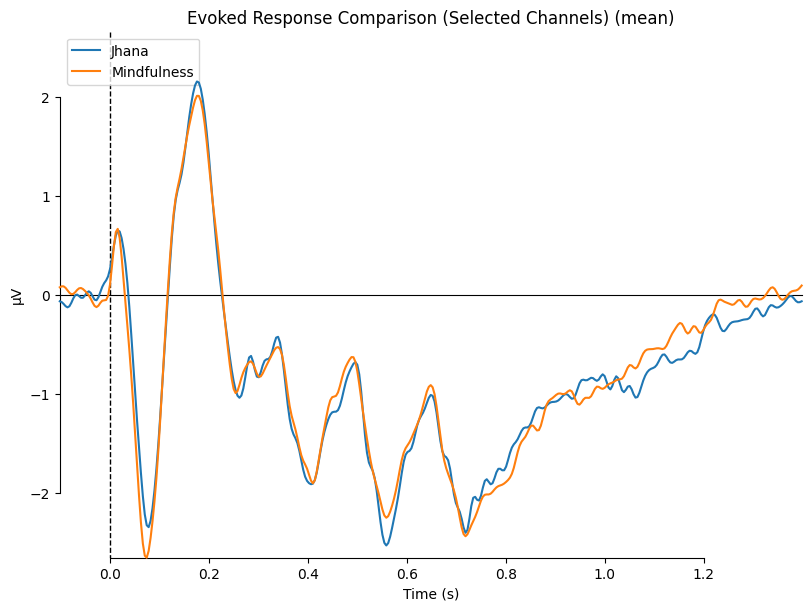

[<Figure size 800x600 with 1 Axes>]

In [250]:
#############################
### plot compared evokeds ###
#############################

evo_jhana = mne.combine_evoked(evokeds['jhana']['all'], weights='equal')
evo_mindfulness = mne.combine_evoked(evokeds['mindfulness']['all'], weights='equal')

evo_mindfulness.plot()
evo_mindfulness.plot()


channel_selection = ['Fz', 'Cz', 'FC1', 'FC2']
time_window = (-0.1, 1.4)

evo_jhana_selected = evo_jhana.copy().pick_channels(channel_selection).crop(tmin=time_window[0], tmax=time_window[1])
evo_mindfulness_selected = evo_mindfulness.copy().pick_channels(channel_selection).crop(tmin=time_window[0], tmax=time_window[1])

evo_jhana_selected = evo_jhana.copy().crop(tmin=time_window[0], tmax=time_window[1])
evo_mindfulness_selected = evo_mindfulness.copy().crop(tmin=time_window[0], tmax=time_window[1])


evokeds_to_compare = {
    'Jhana': evo_jhana_selected,
    'Mindfulness': evo_mindfulness_selected
}

mne.viz.plot_compare_evokeds(evokeds_to_compare, combine='mean', title="Evoked Response Comparison (Selected Channels)")



In [276]:
###########################
### paired sample ttest ###
###########################


start = 0
end = 0.1
channel_selection = ['Fz', 'Cz', 'FC1', 'FC2']
channel_selection = ['Fz']
evokeds_array_t = cut_array(evokeds_array, start, end, channel_selection=channel_selection, channel_names=evo_jhana.ch_names)

a = evokeds_array_t[:,0,3,:,:].mean(axis=(1,2))
b = evokeds_array_t[:,1,3,:,:].mean(axis=(1,2))
print (ttest_rel(a, b))


start = 0.15
end = 0.2
channel_selection = ['Fz', 'Cz', 'FC1', 'FC2']
evokeds_array_t = cut_array(evokeds_array, start, end, channel_selection=channel_selection, channel_names=evo_jhana.ch_names)

a = evokeds_array_t[:,0,3,:,:].mean(axis=(1,2))
b = evokeds_array_t[:,1,3,:,:].mean(axis=(1,2))
print (ttest_rel(a, b))


TtestResult(statistic=np.float64(3.4214102920362293), pvalue=np.float64(0.007610932599080169), df=np.int64(9))
TtestResult(statistic=np.float64(1.4868031500358023), pvalue=np.float64(0.1712362955749135), df=np.int64(9))


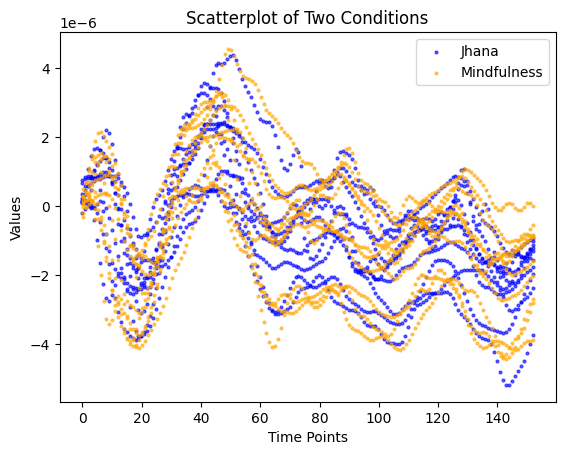

In [235]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace X with your actual data)
# X[0] and X[1] are arrays of shape (10, n_timepoints)
n_timepoints = X[0].shape[1]

# Generate time points (x-axis values)
time = np.arange(n_timepoints)

# Scatter plot for condition 1
for t in range(n_timepoints):
    plt.scatter(
        [time[t] - 0.1] * 10, X[0][:, t], color='blue', alpha=0.6, 
        label='Jhana' if t == 0 else "", s=4  # Smaller dots with `s=10`
    )

# Scatter plot for condition 2
for t in range(n_timepoints):
    plt.scatter(
        [time[t] + 0.1] * 10, X[1][:, t], color='orange', alpha=0.6, 
        label='Mindfulness' if t == 0 else "", s=4  # Smaller dots with `s=10`
    )

# Add labels and legend
plt.xlabel("Time Points")
plt.ylabel("Values")
plt.title("Scatterplot of Two Conditions")
plt.legend()
plt.show()
